In [1]:
# Standard Libraries
from os import environ
import math
from pathlib import Path
from collections import namedtuple
import sys, os

# Third-party Libraries
from citrination_client import CitrinationClient
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets
import interpretability_example.interpretability_utils as interpretability_utils
import utils.API_utils as API_utils
import utils.df_citrination_utils as df_citrination_utils

To do interpretability analysis, we need the following: 
- Python 3.6+, jupyter, urllib, pandas, numpy, urllib, pypif, citrination-client
- The citrination delpoyment and its key, preferably stored as an environment variable
- view: The view ID on that deployment which has the models you need 
- reference_filename: To calculate the range in which to vary a feature. The columns in this file should have all the required inputs but need not be featurized. The column names should correspond to the actual column names in the view (and not template-csv format). This file should contain all of your data.

### Provide all the files and other inputs needed for processing

In [22]:
client = CitrinationClient(environ['CITRINATION_API_KEY'], 'https://citrination.com')
%matplotlib inline

# The directory where your dataset is stored
data_dir = ""

# A citrination dataview which will be used for prediction
view = ""

# A csv containing your data
reference_filename = os.path.join(data_dir, "training_data.csv")

# The path where you would like figures saved
output_path = data_dir

# The data frame column name (str) you wish to predict
output_keys = []

# keys to exclude from input. This should be keys that you'd like to prevent featurization on 
# since we'll be varying the featurized vector directly
keys_to_exclude = [] 


This program will take each feature listed in the fi_filename, and vary it in the range of its variation seen in the reference dataset. It will plot the predicted value vs. feature value for each such feature. The predictions will be made using the model stored on Citrination.    

### Inspect your DataView and choose features

#### Load metadata from your dataview and extract avilable features and outputs

In [23]:
# Import the metadata (column names) for 'view'
dv_client = client.data_views
view_metadata = dv_client.get(view)

In [24]:
# Import the metadata (column names) for 'view'
dv_client = client.data_views
view_metadata = dv_client.get(view)

# Extract metadata of interest, here column labels
column_names = view_metadata['configuration']['roles']

# Extract outputs from view metadata 
output_features = [key for key, value in column_names.items() if value == 'output']

#### Define UI widgets

In [25]:
# Creates a dropdown menu for the output or reference
reference_dropdown = widgets.Dropdown(options = output_features,
              description = 'Reference')

# Generate checkbox widget for each column name
Checkbox = namedtuple('Checkbox', ['name','widget'])
checkboxes = []
input_features = [key for key, value in column_names.items() if value == 'input']

for name in input_features:
    desc = name.replace('_', ' ')
    widge = widgets.Checkbox(description = desc)
    cb = Checkbox(name, widge)
    checkboxes.append(cb)

#### Use the widgets to configure the point about which you would like to vary
Please select your reference property and which features you would like to vary.

<span style="color:red"> **NOTE - notebook will not work when selecting less than all features** </span>


In [26]:
# Display reference dropdown widget
display(reference_dropdown)

# Display feature checkbox widgets
for checkbox in checkboxes:
    display(checkbox.widget)

Dropdown(description='Reference', options=('Property I0_fraction_sphere', 'Property crystalline_flag', 'Proper…

Checkbox(value=False, description='Property ODE extra fraction')

Checkbox(value=False, description='Property oleylamine fraction')

Checkbox(value=False, description='Property TOP fraction')

Checkbox(value=False, description='Property flowrate')

Checkbox(value=False, description='Property T set')

Please define the point around which you would like to vary.

In [27]:
# Store the chosen features from the checkboxes
features = {checkbox.name: checkbox.widget.value for  checkbox in checkboxes}
features = [key for key, value in features.items() if value == True]

# Generate fields to store the center point values
style = {'description_width': 'initial'}
inputs = [widgets.Text(description=feature, style=style) for feature in features]

# Discplay the entry fields for the center point
for inp in inputs:
    display(inp)

Text(value='', description='Property ODE_extra_fraction', style=DescriptionStyle(description_width='initial'))

Text(value='', description='Property oleylamine_fraction', style=DescriptionStyle(description_width='initial')…

Text(value='', description='Property TOP_fraction', style=DescriptionStyle(description_width='initial'))

Text(value='', description='Property flowrate', style=DescriptionStyle(description_width='initial'))

Text(value='', description='Property T_set', style=DescriptionStyle(description_width='initial'))

In [28]:
# Store the center point configuration values from the entry fields
config = {inp.description: [float(inp.value)] for inp in inputs}

# Extract user selections and center point values from the UI
FeatureConfiguration = namedtuple('FeatureConfiguration', ['reference', 'features', 'config'])
feature_configuration = FeatureConfiguration([reference_dropdown.value], features, config)

# Display user configuration for the local optimization study
print('Targeting reference feature: {}\n\nVarying features:'.format(feature_configuration.reference[0]))
for value in feature_configuration.features:
    print(value)
print('\nCentered upon:')
for key, value in feature_configuration.config.items():
    print('{}: {}'.format(key, value[0]))
    
# Prepare the DataFrames from the user configuration
df_center_pt = pd.DataFrame.from_dict(data=feature_configuration.config)
imp_feature_keys = feature_configuration.features
output_keys = feature_configuration.reference

Targeting reference feature: Property r0_sphere

Varying features:
Property ODE_extra_fraction
Property oleylamine_fraction
Property TOP_fraction
Property flowrate
Property T_set

Centered upon:
Property ODE_extra_fraction: 0.2
Property oleylamine_fraction: 0.2
Property TOP_fraction: 0.2
Property flowrate: 100.0
Property T_set: 200.0


### Preparing the reference dataset

In [29]:
featurized_df_ref = pd.read_csv(reference_filename)
for output_key in output_keys:
    featurized_df_ref[output_key] = ""

### Preparing the center point

In [30]:
featurized_df_center = df_center_pt
for output_key in output_keys:
    featurized_df_center[output_key] = ""

### Varying the important features and making predictions

In [31]:
interpretability_inputs = pd.concat(
                            [interpretability_utils.get_inputs_vary_feature_from_refdf(
                            feature, featurized_df_ref, featurized_df_center) 
                            for feature in imp_feature_keys], axis = 0)
interpretability_inputs = interpretability_inputs.drop(
                            [key for key in interpretability_inputs.columns if 
                            (" uncertainty" in key)], axis = 1)

In [32]:
interpretability_predictions = API_utils.batch_predict_through_API(view = view, 
                         input_df = interpretability_inputs.drop(keys_to_exclude, axis=1), 
                         client = client, batch_size = 32)
all_inputs = list(set(interpretability_inputs.columns) - 
                  set(output_keys) - set(keys_to_exclude))

Running 10 batches of batchSize 32


### Plot the results

In [33]:
df_center_pt_predicted = API_utils.predict_one_batch_with_API(view, df_center_pt, client, max_batch_size = 32)

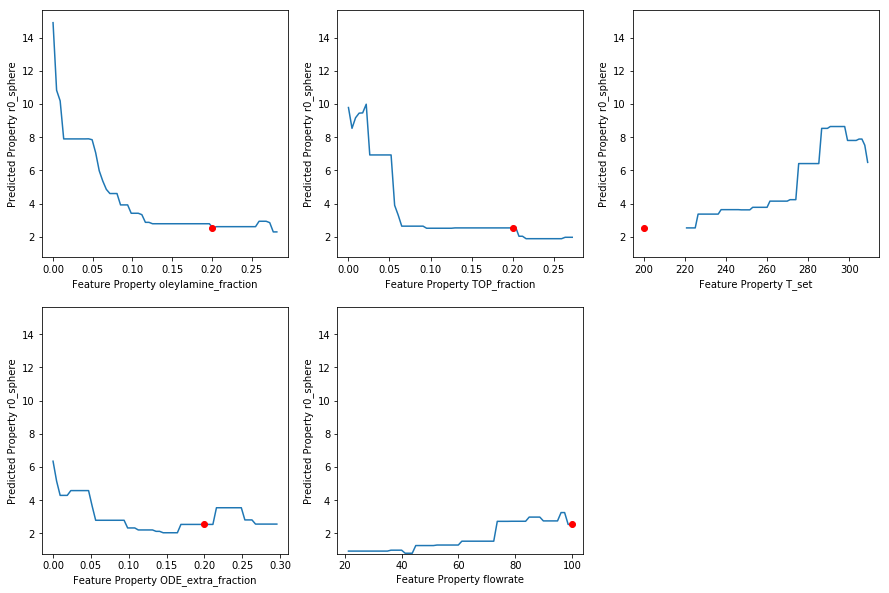

In [34]:
for output in output_keys:
    top_features = interpretability_utils.get_top_features(imp_feature_keys, output,
                all_inputs, interpretability_predictions, n_top_features=6)
    n_cols = 3
    n_rows = math.ceil(len(top_features)/n_cols)
    plt.figure(figsize=(15,10))
    for j, varied_feature in enumerate(reversed(top_features)):
        df = interpretability_utils.get_sliced_df_for_feature(varied_feature, all_inputs, interpretability_predictions).sort_values(by = varied_feature)
        plt.subplot(n_rows, n_cols, j+1)
        plt.plot(df[varied_feature], df[output])
        plt.plot(df_center_pt_predicted[varied_feature], df_center_pt_predicted[output], 'ro') 
        plt.ylim(interpretability_predictions[output].min()*0.95 , interpretability_predictions[output].max()*1.05)
        plt.xlabel('Feature ' + str(varied_feature))
        plt.ylabel('Predicted ' + str(output))
    plot_filename = os.path.join(output_path, output + "_interpret.png")
    plt.savefig(plot_filename)